In [58]:
from methods.stress_classes import StressTensor

my_new_stress_tensor = StressTensor(principal_stresses=[10, 20, 60], trend=30, plunge=5, rake=3)
my_new_stress_tensor.tensor

array([[12.34749468,  3.88170857,  3.78030942],
       [ 3.88170857, 18.03210343, -2.12996458],
       [ 3.78030942, -2.12996458, 59.62040189]])

[[12.5         4.33012702  0.        ]
 [ 4.33012702 17.5         0.        ]
 [ 0.          0.         60.        ]]


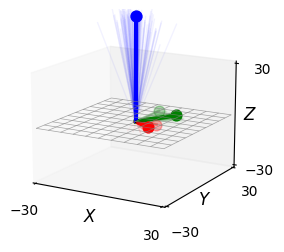

In [ ]:
from methods.stress_classes import RandomStressTensor
from methods.stress_plotting import plot_stress_tensor_with_rotated_ensemble 

# Создание ансамбля случайных тензоров
# Просто ансамбль с нормальнымираспределениями всех величин
tensor = RandomStressTensor([10, 20, 60], trend=30, plunge=0, rake=0)
ensemble_tensors, stresses, trends, plunges, rakes = tensor.generate_ensemble(
    N=200,
    stress_std_frac=0.05,
    angle_std_deg=10,
)

print(tensor) # материнский тензор

# отрисовка ансамбля тензоров
plot_stress_tensor_with_rotated_ensemble(
    tensor,
    ensemble_stresses=stresses,
    ensemble_trends=trends,
    ensemble_plunges=plunges,
    ensemble_rakes=rakes,
    max_ensemble_to_plot=100
)

# после генерации параметры ансамбля доступны в виде атрибутов обьекта tensor:
stresses = tensor.ensemble_principal_stresses # например значения главных компонент

[[19.26124338  0.          0.        ]
 [ 0.         39.63062169  0.        ]
 [ 0.          0.         60.        ]]


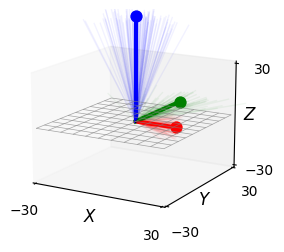

In [52]:
from methods.stress_classes import FrictionalStressTensor
from methods.stress_plotting import plot_stress_tensor_with_rotated_ensemble 

tensor = FrictionalStressTensor(s1=60, mode='zyx', ratio=0.5, pore_pressure=0.123, mu=0.6, cohesion=0.05, trend=0, plunge=0, rake=0)
ensemble_tensors, stresses, trends, plunges, rakes = tensor.generate_ensemble(
    N=200,
    stress_std_frac=0.05,
    angle_std_deg=10,
    random_s2 = True, # будем делать промежуточное главное напряжение случайным между максимальным и минимальным
)

print(tensor) # материнский тензор

# отрисовка ансамбля тензоров
plot_stress_tensor_with_rotated_ensemble(
    tensor,
    ensemble_stresses=stresses,
    ensemble_trends=trends,
    ensemble_plunges=plunges,
    ensemble_rakes=rakes,
    max_ensemble_to_plot=100
)

# после генерации параметры ансамбля доступны в виде атрибутов обьекта tensor:
stresses = tensor.ensemble_principal_stresses # например значения главных компонент

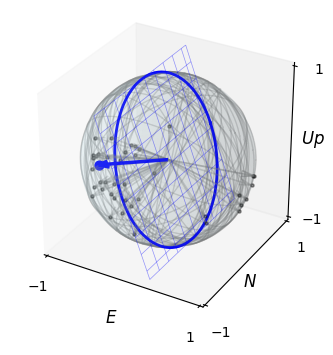

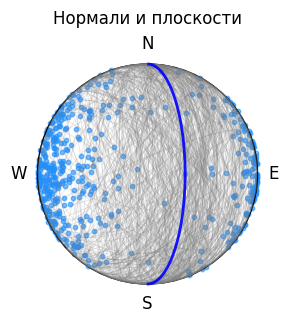

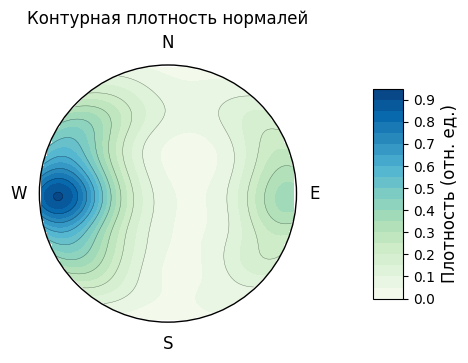

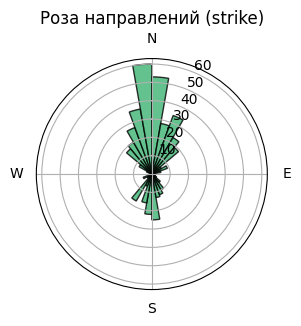

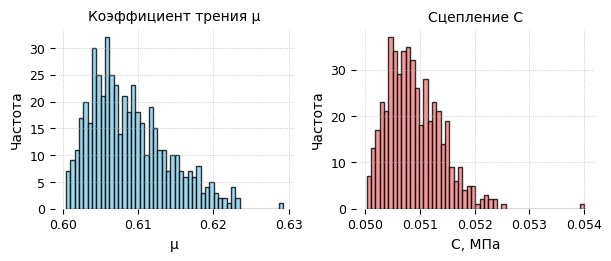

In [ ]:
from methods.frac_classes import RandomFractureSeed, FisherFractureSeed
from methods.frac_plotting import plot_fracture_ensemble_on_sphere, plot_fracture_normals_and_planes, plot_fracture_density, plot_fracture_strike_rose, plot_mu_cohesion_histograms


# Создание ансамблей трещин, ориентированных согласно распределению Фишера
# коэффициенты трения и когезии могут быть одинаковы для всех трещин, 
# либо можно сделать распределенными согласно распределению Вейбулла, 
# тогда нужно передать параметры распределения, см описание класса

# создаём объект матринской трещины:
seed = FisherFractureSeed(strike=0, dip=70, mu=0.6, cohesion=0.05)

# параметры материнской трещины доступны в атрибутах объекта, например
seed.mu, seed.normal # и т.д.

# генерируем для него ансамбль из нужного количства случайно ориентированных трещин. 
# Если не задавать параметры масштаба, типа mu_weibull_scale, то все коэффициенты mu будут как у матринской трещины
# получаем пассив из N векторов нормалей к плоскости трещин, и всего прочего, что может понадобится
normals, strikes, dips, mus, cohesions = seed.generate_ensemble(N=500, kappa=5, mu_weibull_scale=0.01, cohesion_weibull_scale=0.001)

# для ориентаций трещин можно воспользоваться другим классом, с нормально распределенными углами страйк и дип,
# возможно это в будущем пригодится для модели восстановления ориентации
# seed = RandomFractureSeed(strike=10, dip=90)
# normals, strikes, dips, mus, cohesions = seed.generate_ensemble(N=500, strike_std=20, dip_std=20)

# визуализация разными способами
plot_fracture_ensemble_on_sphere(normals, seed)
plot_fracture_normals_and_planes(normals, seed)
plot_fracture_density(normals)
plot_fracture_strike_rose(strikes)

# Распрелделения параметров трения и когезии для ансамбля:
plot_mu_cohesion_histograms(mus, cohesions)

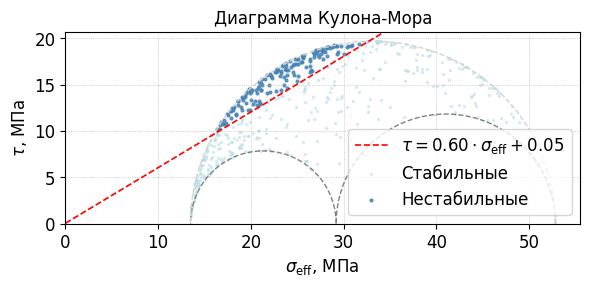

In [56]:
from methods.colomb_things import critical_pore_pressure, compute_normal_and_shear_ensemble, check_coulomb_failure
from methods.colomb_things_plotting import plot_coulomb_diagram

# считает, какео должно быть поровое давление для материнского тензора и сида, 
# чтобы большой круг Мора коснулся критерия Кулона. То есть это нужный сдвиг круга вдоль оси сигма н до точки касания с прямой
# Ответ в тех же единицах, что и стресс - в МПа
crit_press = critical_pore_pressure(tensor, seed) 
# если tensor - объект класса FrictionalStressTensor, то это давление, очевидно, будет такое же, как было задано при его инициализации

# Можно считать, какие трещины критически напряжены, для этого есть две функции:

# Нормальные и касательные напряжения. Считается сразу для всего бэтча из тензоров.
# Каждый тензор из ансамбля пересчитывается в нормальные и касательные напряжения для каждой нормали.
sigma_n, tau = compute_normal_and_shear_ensemble(ensemble_tensors, normals)

# Чекаем, для каких ттерин выполнился критерий Кулона, также сразу для всех тензоров. 
# В качестве порового давления подставляем каке то, в даннлм случае критическое + 5 МПа.
failures = check_coulomb_failure(sigma_n, tau, mus, cohesions, pore_pressure=crit_press+5)

# можно визуализировать всю красоту в виде диграммы Кулона
idx=42 # номер какого то тензора из батча тензоров напряжений

# для него:
sigma_n = sigma_n[idx] # нормальные напряжения для всех трещин из ансамбля
tau = tau[idx] # касательные напряжения для всех трещин из ансамбля
mu = seed.mu # коэффициенты трения и когезии для отрисовки прямой критерия
cohesion = seed.cohesion 
principal_stresses = stresses[idx] # главные компоненты тензора напряжений для отрисовки кругов Мора
failures=failures[idx] # метки выполенности критерия Кулона для трещин из ансамбля, чтобы точки по разному раскрасить, можно не передаватьтогда сами посчитаются

plot_coulomb_diagram(sigma_n, tau, mu, cohesion, pore_pressure=crit_press+5, principal_stresses=principal_stresses, failures=failures)

In [39]:
# Объект с параметрами моделирования
params = SimpleNamespace(
    trend=-20,
    plunge=20,
    rake=0,
    n_tensors=10,
    stress_std_frac=0.05,
    angle_std_deg=2,
    fracture_strike=10,
    fracture_dip=60,
    fracture_mu=0.83,
    fracture_cohesion=0.01,
    n_fractures=100000,
    strike_std=2,
    dip_std=2,
    mu_weibull_scale_factor=0.01,
    cohesion_weibull_scale_factor=0.3,
)

# Шаг 0: Вычисление главных компонент тензора напряжений
ro_s=2800 # kg/m3
poisson=0.3 
depth=1750 # m (Дич. -> 2000 !!)

sv = ro_s * 9.81 * depth * 1e-6  # MPa
sh = sH = poisson/(1-poisson) * sv
loc_main_stress=[sh, sH, sv]

# Шаг 1: Загрузка давления из файла, если надо из файла
# print("Загрузка давления...")
# pressure_file='press_calc_2025-04-23_12-58-45.h5'
# with h5py.File(pressure_file, "r") as f:
#     pore_pressure = f['data'][:]
#     time = f['times'][:]
# point_of_interest = (20, 10, 80)
# x0, y0, z0 = point_of_interest
# pore_pressure_vs_time = pore_pressure[:, x0, y0, z0].copy() # изменение порового давления в нужной точке (T,)
# pore_pressure = None # сэкономили немного памяти


# Шаг 2: Генерация тензоров напряжений (N,)
print("Генерация ансамбля тензоров...")
tensor = StressTensor(loc_main_stress,
                      trend=params.trend,
                      plunge=params.plunge,
                      rake=params.rake)
tensors, principal_stresses, trends, plunges, rakes = tensor.generate_ensemble(
    n=params.n_tensors, # N
    stress_std_frac=params.stress_std_frac,
    angle_std_deg=params.angle_std_deg
)

# Шаг 3: Генерация трещин (M,)
print("Генерация ансамбля трещин...")
seed = FractureSeed(strike=params.fracture_strike,
                    dip=params.fracture_dip,
                    mu=params.fracture_mu,
                    cohesion=params.fracture_cohesion)
normals, strike, dip, mu, cohesion = seed.generate_random_normals(
    n=params.n_fractures, # M
    strike_std=params.strike_std,
    dip_std=params.dip_std,
    mu_weibull_scale=params.fracture_mu * params.mu_weibull_scale_factor,
    cohesion_weibull_scale=params.fracture_cohesion * params.cohesion_weibull_scale_factor
)

# Делаем мок давление для всего диапазона давлений, когда вообще возможны какие то события, то есть от касания до порового, равного максимальному
p_ini = critical_pore_pressure(tensor, seed) -5 # может быть как плюс, так иминус
p_max = np.max(tensor.principal_stresses) +5
steps = 1000
print("Создание мок-давления...")
pore_pressure_vs_time = np.linspace(p_ini, p_max, steps)
time = np.linspace(0, steps*3600, steps) # костыль, 1000 часов
# конец генерации мок-давления

# Шаг 4: Расчёт нормальных и касательных напряжений
sigma_n, tau = compute_normal_and_shear_ensemble(tensors, normals) # (N, M)

# Шаг 5: Расчёт событий
print("Расчёт микросейсмических событий...")
events_vs_time = simulate_microseismicity_over_time(sigma_n, tau, mu, cohesion, pore_pressure_vs_time,)

print("✅ Готово!")



Генерация ансамбля тензоров...
Генерация ансамбля трещин...
Создание мок-давления...
Расчёт микросейсмических событий...
Проверка критерия Кулона-Мора по времени...


Временные шаги:   0%|          | 0/1000 [00:00<?, ?it/s]

✅ Готово!


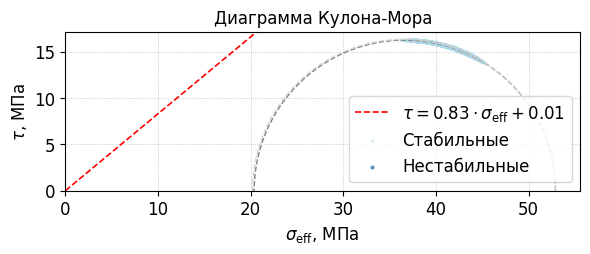

In [50]:
idx=1
plot_coulomb_diagram(sigma_n[idx], tau[idx], mu = seed.mu, cohesion = seed.cohesion, pore_pressure=0, principal_stresses=principal_stresses[idx])

In [31]:
# Нормированные время и количество событий
times, binned_events = compute_normalized_event_curve(time, events_vs_time[1], time_unit='h')

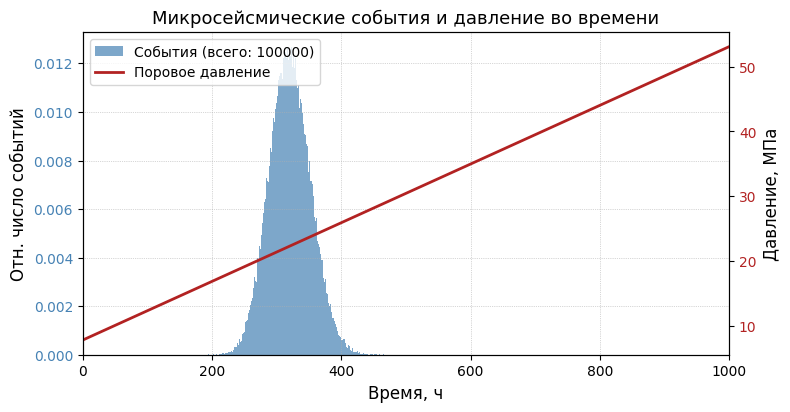

In [46]:
# график
plot_events_and_pressure(time, events_vs_time[1], pore_pressure_vs_time, time_unit='h') 

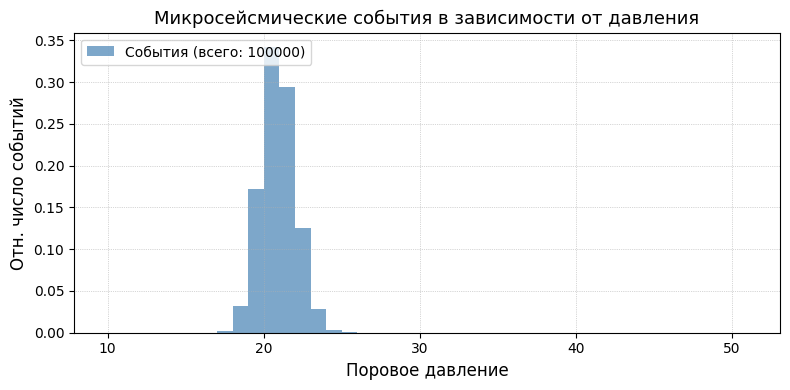

In [43]:
plot_events_vs_pressure(pore_pressure_vs_time, events_vs_time[8])

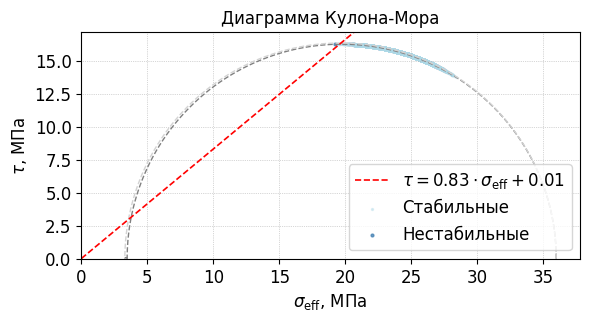

In [52]:
idx=1
t = 200

failures = check_coulomb_failure(sigma_n, tau, mu, cohesion, pore_pressure=pore_pressure_vs_time[t])

plot_coulomb_diagram(sigma_n[idx], tau[idx], mu = seed.mu, cohesion = seed.cohesion, 
                     pore_pressure=pore_pressure_vs_time[t], 
                     principal_stresses=principal_stresses[idx], 
                     failures=failures[idx])

### Всякие рабочие моменты

In [ ]:
# первая итерация

class StressTensor:
    def __init__(self, principal_stresses=np.array([1, 1, 1]), strike=0, dip=0):
        """
        Создание тензора напряжений на основе главных компонент и ориентации в пространстве.

        Аргументы:
        - principal_stresses: np.ndarray формы (3,) — главные напряжения σ1, σ2, σ3.
          Задают величины в локальной системе координат (до поворота).
        - strike: float — азимут (strike), угол поворота в горизонтальной плоскости вокруг оси Z, [градусы].
          Отсчитывается по часовой стрелке от севера (ось Y) к востоку (ось X).
        - dip: float — угол падения (dip), поворот вокруг НОВОЙ оси Y после strike, [градусы].
          Отсчитывается вниз (в положительном направлении), z → x при 90°.
        """
        self.principal_stresses = np.array(principal_stresses)
        self.strike = strike
        self.dip = dip

        # Получаем поворотную матрицу (strike → dip)
        self.rotation_matrix = StressTensor.build_rotation_matrix(
            np.array([self.strike]), np.array([self.dip])
        )[0]

        # Получаем сам повернутый тензор (σ' = R · σ · R^T)
        self.tensor = StressTensor.build_tensor_batch(
            self.principal_stresses[np.newaxis, :],
            np.array([self.strike]),
            np.array([self.dip])
        )[0]

    def __str__(self):
        return self.tensor.__str__()

    @staticmethod
    def build_rotation_matrix(strike_batch, dip_batch):
        """
        Строит массив поворотных матриц (n, 3, 3) на основе углов strike и dip в градусах.

        Возвращает:
        - R: np.ndarray (n, 3, 3) — поворотные матрицы
        """
        # Поворот вокруг вертикальной оси (strike), по часовой — минус
        theta_h = np.radians(-strike_batch)

        # Поворот вокруг новой оси y (dip)
        theta_v = np.radians(dip_batch)
        n = len(strike_batch)

        # Горизонтальный поворот (вокруг Z)
        R_h = np.zeros((n, 3, 3))
        R_h[:, 0, 0] = np.cos(theta_h)
        R_h[:, 0, 1] = -np.sin(theta_h)
        R_h[:, 1, 0] = np.sin(theta_h)
        R_h[:, 1, 1] = np.cos(theta_h)
        R_h[:, 2, 2] = 1.0

        # Вертикальный поворот (вокруг новой оси Y)
        R_v = np.zeros((n, 3, 3))
        R_v[:, 0, 0] = np.cos(theta_v)
        R_v[:, 0, 2] = np.sin(theta_v)
        R_v[:, 1, 1] = 1.0
        R_v[:, 2, 0] = -np.sin(theta_v)
        R_v[:, 2, 2] = np.cos(theta_v)

        # Общий поворот: сначала strike, затем dip → R = Rv @ Rh
        R = np.einsum('nij,njk->nik', R_v, R_h)
        return R

    @staticmethod
    def build_tensor_batch(principal_stresses_batch, strike_batch, dip_batch):
        """
        Генерирует массив повернутых тензоров из набора параметров.

        Аргументы:
        - principal_stresses_batch: (n, 3) — массив главных напряжений σ1, σ2, σ3
        - strike_batch: (n,) — углы strike (в градусах)
        - dip_batch: (n,) — углы dip (в градусах)

        Возвращает:
        - rotated_tensors: (n, 3, 3) — повернутые тензоры в глобальной системе координат
        """
        R = StressTensor.build_rotation_matrix(strike_batch, dip_batch)

        # Сборка диагональных матриц главных напряжений
        T = np.zeros((len(principal_stresses_batch), 3, 3))
        T[:, 0, 0] = principal_stresses_batch[:, 0]
        T[:, 1, 1] = principal_stresses_batch[:, 1]
        T[:, 2, 2] = principal_stresses_batch[:, 2]

        # Поворот: R · T · R^T
        rotated_tensors = np.einsum('nij,njk,nlk->nil', R, T, R)
        return rotated_tensors

    def generate_random_tensors(self, stress_std_frac, angle_std_deg, n=10):
        """
        Генерация ансамбля случайных тензоров на основе нормальных распределений параметров.

        Аргументы:
        - stress_std_frac: (3,) — стандартные отклонения главных напряжений в долях от их значений
        - angle_std_deg: float или (float, float) — стандартное отклонение углов strike и dip (в градусах)
        - n: int — количество реализаций

        Возвращает:
        - tensors: (n, 3, 3) — повернутые тензоры
        - stress_samples: (n, 3) — сгенерированные главные напряжения
        - strike_samples: (n,) — сгенерированные углы strike
        - dip_samples: (n,) — сгенерированные углы dip
        """
        if isinstance(angle_std_deg, (float, int)):
            strike_std = dip_std = angle_std_deg
        else:
            strike_std, dip_std = angle_std_deg

        # Генерация главных напряжений
        stress_samples = np.random.normal(
            loc=self.principal_stresses,
            scale=self.principal_stresses * stress_std_frac,
            size=(n, 3)
        )

        # Генерация углов поворота
        strike_samples = np.random.normal(loc=self.strike, scale=strike_std, size=n)
        dip_samples = np.random.normal(loc=self.dip, scale=dip_std, size=n)

        tensors = StressTensor.build_tensor_batch(stress_samples, strike_samples, dip_samples)
        return tensors, stress_samples, strike_samples, dip_samples
  

def plot_stress_tensor_with_rotated_ensemble(tensor,
                                              ensemble_stresses=None,
                                              ensemble_strikes=None,
                                              ensemble_dips=None,
                                              max_ensemble_to_plot=100):
    """
    Отображает главный тензор напряжений (исходный и повернутый),
    а также ансамбль случайных тензоров на основе их главных осей.

    Аргументы:
    - tensor: StressTensor — основной эталонный тензор
    - ensemble_stresses: (n, 3) — массив сгенерированных главных напряжений
    - ensemble_strikes: (n,) — массив углов strike (в градусах)
    - ensemble_dips: (n,) — массив углов dip (в градусах)
    - max_ensemble_to_plot: int — максимальное количество реализаций для отображения
    """
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['red', 'green', 'blue']
    marker_size = 60

    # Построение исходных и повернутых осей
    original_vectors = np.diag(tensor.principal_stresses)  # локальная система
    rotated_vectors = tensor.rotation_matrix @ original_vectors  # в глобальной системе

    for i in range(3):
        # Исходные оси
        ax.plot([0, original_vectors[0, i]],
                [0, original_vectors[1, i]],
                [0, original_vectors[2, i]],
                color=colors[i], alpha=0.3, linewidth=2)
        ax.scatter(*original_vectors[:, i], color=colors[i], alpha=0.3, s=marker_size)

        # Повернутые оси
        ax.plot([0, rotated_vectors[0, i]],
                [0, rotated_vectors[1, i]],
                [0, rotated_vectors[2, i]],
                color=colors[i], alpha=1.0, linewidth=3)
        ax.scatter(*rotated_vectors[:, i], color=colors[i], alpha=1.0, s=marker_size)

    # Отображение ансамбля
    if (ensemble_stresses is not None
        and ensemble_strikes is not None
        and ensemble_dips is not None):

        n = min(max_ensemble_to_plot, ensemble_stresses.shape[0])

        # Поворотные матрицы и масштабированные главные оси
        R = StressTensor.build_rotation_matrix(ensemble_strikes[:n], ensemble_dips[:n])
        unit_axes = np.eye(3)[np.newaxis, :, :]
        rotated_axes = np.einsum('nij,njk->nik', R, unit_axes)
        scaled_axes = rotated_axes * ensemble_stresses[:n, np.newaxis, :]

        for axes in scaled_axes:
            for i in range(3):
                ax.plot([0, axes[0, i]],
                        [0, axes[1, i]],
                        [0, axes[2, i]],
                        color=colors[i], alpha=0.05, linewidth=1)

    # Настройка масштаба и тиков
    max_val = np.max(np.abs(tensor.principal_stresses))
    scale = max(10, np.ceil(max_val / 5) * 2.5)
    # ticks = np.arange(-scale, scale + 1, 10)
    ticks = [-scale, scale]

    ax.set_xlim([-scale, scale])
    ax.set_ylim([-scale, scale])
    ax.set_zlim([-scale, scale])
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_zticks(ticks)

    # Ручные подписи осей
    ax.text(0, -1.3 * scale, -1.2 * scale, r'$\sigma_{xx}$', fontsize=12)
    ax.text(scale, 0, -1.3 * scale, r'$\sigma_{yy}$', fontsize=12)
    ax.text(scale, 1.3 * scale, 0, r'$\sigma_{zz}$', fontsize=12)

    # Легенда
    custom_lines = [
        Line2D([0], [0], color='blue', lw=3, label='Повернутый тензор'),
        Line2D([0], [0], color='blue', lw=2, alpha=0.3, label='Исходный тензор'),
        Line2D([0], [0], color='gray', lw=1, alpha=0.3, label='Случайные тензоры')
    ]
    ax.legend(handles=custom_lines, loc='upper left', fontsize=8)

    ax.view_init(elev=15)
    plt.show()



In [ ]:
# первая итерация

class FractureSeed:
    def __init__(self, strike=0.0, dip=0.0, mu=0.83, cohesion=0.1):
        """
        Класс, описывающий ориентацию и параметры трещины. Возвращает нормаль к трещине. Нормаль направлена вниз для горизонтальной трещины.
        """
        self.strike = strike
        self.dip = dip
        self.mu = mu
        self.cohesion = cohesion

        # Поворотная матрица и нормаль
        self.rotation_matrix = FractureSeed.build_rotation_matrix(
            np.array([self.strike]), np.array([self.dip])
        )[0]
        self.normal = self.rotation_matrix @ np.array([0, 0, -1])

    @staticmethod
    def build_rotation_matrix(strike_batch, dip_batch):
        """
        Построение поворотных матриц (n, 3, 3) из strike и dip (в градусах).
        Сначала dip: наклон вокруг оси Y (локально, вниз),
        затем strike: поворот вокруг глобальной оси Z (азимут).
        """
        theta_v = np.radians(dip_batch)           # dip
        theta_h = np.radians(-strike_batch)       # strike по часовой → минус

        n = len(strike_batch)

        # Поворот вокруг оси Y (dip) — направлен от z к +x
        R_dip = np.zeros((n, 3, 3))
        R_dip[:, 0, 0] = np.cos(theta_v)
        R_dip[:, 0, 2] = np.sin(theta_v)  
        R_dip[:, 1, 1] = 1.0
        R_dip[:, 2, 0] = -np.sin(theta_v)  
        R_dip[:, 2, 2] = np.cos(theta_v)

        # Поворот вокруг оси Z (strike)
        R_strike = np.zeros((n, 3, 3))
        R_strike[:, 0, 0] = np.cos(theta_h)
        R_strike[:, 0, 1] = -np.sin(theta_h)
        R_strike[:, 1, 0] = np.sin(theta_h)
        R_strike[:, 1, 1] = np.cos(theta_h)
        R_strike[:, 2, 2] = 1.0

        # Общий поворот: сначала dip, затем strike
        R = np.einsum('nij,njk->nik', R_strike, R_dip)
        return R

    @staticmethod
    def build_normal_batch(strike_batch, dip_batch):
        """
        Построение нормалей к плоскостям (n, 3) — поворот изначального вертикального вектора.
        """
        R = FractureSeed.build_rotation_matrix(strike_batch, dip_batch)
        n0 = np.array([0, 0, -1])
        normals = np.einsum('nij,j->ni', R, n0)
        return normals

    def generate_random_normals(self,
                                n: int,
                                strike_std: float = 0,
                                dip_std: float = 0,
                                mu_weibull_shape: float = 5.0,
                                mu_weibull_scale: float = None,
                                cohesion_weibull_shape: float = 2.0,
                                cohesion_weibull_scale: float = None,
                                random_seed: int = None):
        """
        Генерация ансамбля нормалей и параметров трещин.

        :return: normals (n, 3),
                 strike_samples (n,),
                 dip_samples (n,),
                 mu_samples (n,),
                 cohesion_samples (n,)
        """
        if random_seed is not None:
            np.random.seed(random_seed)

        if mu_weibull_scale is None:
            mu_weibull_scale = self.mu
        if cohesion_weibull_scale is None:
            cohesion_weibull_scale = self.cohesion

        # Сэмплируем параметры
        strike_samples = np.random.normal(loc=self.strike, scale=strike_std, size=n)
        dip_samples = np.random.normal(loc=self.dip, scale=dip_std, size=n)
        mu_samples = weibull_min.rvs(mu_weibull_shape, scale=mu_weibull_scale, size=n)
        cohesion_samples = weibull_min.rvs(cohesion_weibull_shape, scale=cohesion_weibull_scale, size=n)

        # Нормали
        normals = FractureSeed.build_normal_batch(strike_samples, dip_samples)

        return normals, strike_samples, dip_samples, mu_samples, cohesion_samples
    

def plot_fracture_ensemble_on_sphere(seed,
                                     normals=None,
                                     strike_samples=None,
                                     dip_samples=None,
                                     max_ensemble_to_plot=40):
    """
    Визуализация:
    - Сфера
    - Сечения трещин (ансамбль и материнская)
    - Векторы нормалей
    - Точки пересечения нормалей со сферой
    - Плоскость материнской трещины с сеткой
    - Стороны света
    """
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')

    def plot_sphere(ax, radius=1.0, alpha=0.1, color='lightblue'):
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = radius * np.outer(np.cos(u), np.sin(v))
        y = radius * np.outer(np.sin(u), np.sin(v))
        z = radius * np.outer(np.ones_like(u), np.cos(v))
        ax.plot_surface(x, y, z, color=color, alpha=alpha, linewidth=0)

    def plot_circle_on_sphere(ax, normal, color='gray', linewidth=1.0, alpha=0.5, n_points=200):
        normal = normal / np.linalg.norm(normal)
        if np.abs(normal[2]) < 0.9:
            v1 = np.cross(normal, [0, 0, 1])
        else:
            v1 = np.cross(normal, [0, 1, 0])
        v1 /= np.linalg.norm(v1)
        v2 = np.cross(normal, v1)

        theta = np.linspace(0, 2 * np.pi, n_points)
        circle = np.outer(np.cos(theta), v1) + np.outer(np.sin(theta), v2)
        ax.plot(circle[:, 0], circle[:, 1], circle[:, 2],
                color=color, linewidth=linewidth, alpha=alpha)

    def plot_plane_with_grid(ax, normal, size=1.0, resolution=20, color='cyan', alpha=0.2):
        normal = normal / np.linalg.norm(normal)
        if np.abs(normal[2]) < 0.9:
            v1 = np.cross(normal, [0, 0, 1])
        else:
            v1 = np.cross(normal, [0, 1, 0])
        v1 /= np.linalg.norm(v1)
        v2 = np.cross(normal, v1)

        u = np.linspace(-size, size, resolution)
        v = np.linspace(-size, size, resolution)
        uu, vv = np.meshgrid(u, v)
        points = uu[..., np.newaxis] * v1 + vv[..., np.newaxis] * v2

        X, Y, Z = points[..., 0], points[..., 1], points[..., 2]
        ax.plot_wireframe(X, Y, Z, color=color, alpha=alpha, linewidth=0.5, rstride=2, cstride=2)

    # Генерация нормалей
    if normals is None and strike_samples is not None and dip_samples is not None:
        normals = FractureSeed.build_normal_batch(strike_samples, dip_samples)

    # Построение
    plot_sphere(ax)

    if normals is not None:
        k = min(len(normals), max_ensemble_to_plot)
        for i in range(k):
            # Окружности
            plot_circle_on_sphere(ax, normals[i], color='gray', linewidth=1.0, alpha=0.3)
            # Векторы
            ax.quiver(0, 0, 0,
                        normals[i, 0], normals[i, 1], normals[i, 2],
                        length=1.0, normalize=True,
                        arrow_length_ratio=0.15,
                        color='gray', alpha=0.3, linewidth=1.2)
            # Точка на сфере
            ax.scatter(normals[i, 0], normals[i, 1], normals[i, 2],
                       color='black', s=5, alpha=0.4)

    # Материнская трещина
    plot_circle_on_sphere(ax, seed.normal, color='blue', linewidth=2.0, alpha=1.0)
    plot_plane_with_grid(ax, seed.normal, size=1.0, resolution=20, color='blue', alpha=0.4)
    ax.quiver(0, 0, 0,
              seed.normal[0], seed.normal[1], seed.normal[2],
              length=1.0, normalize=True,
              arrow_length_ratio=0.15,
              color='blue', linewidth=2.5)
    ax.scatter(seed.normal[0], seed.normal[1], seed.normal[2],
               color='blue', s=40, alpha=1.0)

    # Настройка осей и сторон света
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_box_aspect([1, 1, 1])
    ax.set_xticks([-1, 1])
    ax.set_yticks([-1, 1])
    ax.set_zticks([-1, 1])
    ax.grid(False)

    # Обозначения координат как стороны света
    ax.text(0, -1.4, -1.4, r'$E$', fontsize=12)
    ax.text(1, 0, -1.4, r'$N$', fontsize=12)
    ax.text(1, 1.4, -0.2, r'$Up$', fontsize=12)

    # custom_lines = [
    #     Line2D([0], [0], color='blue', lw=2, label='Материнская трещина'),
    #     Line2D([0], [0], color='gray', lw=1, alpha=0.4, label='Ансамбль трещин'),
    #     Line2D([0], [0], color='black', marker='o', lw=0, label='Нормали на сфере')
    # ]
    # ax.legend(handles=custom_lines, loc='upper left', fontsize=12)

    # plt.tight_layout()
    plt.show()


def plot_fracture_normals_and_planes(normals, seed=None):
    normals = normals / np.linalg.norm(normals, axis=1, keepdims=True)
    normals = normals[normals[:, 2] < 0]
    x, y = normals[:, 0], normals[:, 1]

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_aspect('equal')
    ax.scatter(x, y, s=10, color='dodgerblue', alpha=0.6)

    if seed is not None:
        for n in normals:
            plot_great_circle(ax, n, color='gray', alpha=0.2, linewidth=0.6)
        plot_great_circle(ax, seed.normal, color='blue', linewidth=2.0, alpha=0.9)

    ax.add_patch(Circle((0, 0), 1.0, edgecolor='black', facecolor='none', lw=1))
    ax.set_xlim(-1.05, 1.05);  ax.set_ylim(-1.05, 1.05)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Нормали и плоскости", fontsize=12, pad=25)
    label_cardinal_directions(ax, r=1.1)
    for spine in ax.spines.values():
        spine.set_visible(False)
    # plt.tight_layout()
    plt.show()

def plot_fracture_density(normals):
    #‑‑ подготовка данных
    normals = normals / np.linalg.norm(normals, axis=1, keepdims=True)
    normals = normals[normals[:, 2] < 0]
    x, y = normals[:, 0], normals[:, 1]

    #‑‑ фигурa: основная ось + узкая ось справа под color‑bar
    fig = plt.figure(figsize=(5, 3))
    ax  = fig.add_axes([0.05, 0.05, 0.74, 0.9])   # [left, bottom, width, height]
    ax.set_aspect('equal')
    cax = fig.add_axes([0.83, 0.15, 0.06, 0.7])   # ось под color‑bar

    #‑‑ KDE‑плотность
    xi, yi = np.mgrid[-1:1:100j, -1:1:100j]
    dens = gaussian_kde(np.vstack([x, y]))(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
    dens[(xi**2 + yi**2) > 1] = np.nan

    cf = ax.contourf(xi, yi, dens, levels=20, cmap='GnBu')
    ax.contour(xi, yi, dens, levels=10, colors='k', linewidths=0.3, alpha=.5)

    #‑‑ color‑bar
    cbar = fig.colorbar(cf, cax=cax)
    cbar.set_label("Плотность (отн. ед.)", fontsize=12)

    #‑‑ подпись максимума
    # ax.text(0.98, 0.97, f"MAX = {np.nanmax(dens):.2f}",
    #         transform=ax.transAxes, ha='right', va='top', fontsize=12)

    #‑‑ окружность сферы
    ax.add_patch(Circle((0, 0), 1, ec='k', fc='none', lw=1, zorder=10))
    ax.set_xlim(-1.05, 1.05);  ax.set_ylim(-1.05, 1.05)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title("Контурная плотность нормалей", pad=25, fontsize=12)

    #‑‑ стороны света
    label_cardinal_directions(ax, r=1.10)

    #‑‑ убрать рамку
    for sp in ax.spines.values():
        sp.set_visible(False)

    plt.show()

def plot_fracture_strike_rose(strike_samples, n_bins=36):
    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

    bin_edges = np.linspace(0, 360, n_bins + 1)
    counts, _ = np.histogram(strike_samples % 360, bins=bin_edges)
    theta = np.radians((bin_edges[:-1] + bin_edges[1:]) / 2)

    ax.bar(theta, counts, width=np.radians(360 / n_bins),
           color='mediumseagreen', edgecolor='black', alpha=0.8)

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 90, 180, 270]))
    ax.set_xticklabels(['N', 'E', 'S', 'W'])
    ax.set_title("Роза направлений (strike)", fontsize=12)

    # plt.tight_layout()
    plt.show()


def plot_great_circle(ax, normal, n_points=200, **kwargs):
    normal = normal / np.linalg.norm(normal)
    if np.abs(normal[2]) < 0.9:
        v1 = np.cross(normal, [0, 0, 1])
    else:
        v1 = np.cross(normal, [0, 1, 0])
    v1 /= np.linalg.norm(v1)
    v2 = np.cross(normal, v1)

    theta = np.linspace(0, 2 * np.pi, n_points)
    circle = np.outer(np.cos(theta), v1) + np.outer(np.sin(theta), v2)
    mask = circle[:, 2] < 0
    segments = np.split(circle, np.where(np.diff(mask.astype(int)) != 0)[0] + 1)

    for seg in segments:
        if len(seg) > 1 and np.all(seg[:, 2] < 0):
            ax.plot(seg[:, 0], seg[:, 1], **kwargs)

def label_cardinal_directions(ax, r=1.08, fontsize=12):
    """Рисует подписи N‑E‑S‑W чуть дальше граничного круга."""
    ax.text( 0,  r, 'N', ha='center', va='bottom', fontsize=fontsize)
    ax.text( 0, -r, 'S', ha='center', va='top',    fontsize=fontsize)
    ax.text( r,  0, 'E', ha='left',   va='center', fontsize=fontsize)
    ax.text(-r,  0, 'W', ha='right',  va='center', fontsize=fontsize)

In [ ]:
def generate_fisher_orientations(mean_direction, kappa, N):
    """
    Генерирует случайные ориентации единичных векторов нормалей по распределению Фишера.
    
    Параметры:
    -----------
    mean_direction : array-like, shape (3,)
        Исходное направление (единичный вектор нормали), вокруг которого группируются векторы.
        
    kappa : float
        Параметр кучности распределения Фишера (чем больше kappa, тем сильнее концентрация вокруг mean_direction).
        
    N : int
        Количество генерируемых случайных ориентаций.

    Возвращает:
    -----------
    normals : ndarray, shape (N, 3)
        Массив единичных векторов нормалей согласно распределению Фишера.
    """

    mean_direction = np.array(mean_direction, dtype=float)
    mean_direction /= np.linalg.norm(mean_direction)  # Нормализуем исходный вектор нормали

    # Шаг 1: генерация случайных углов θ согласно распределению Фишера
    # Используем обратное преобразование CDF (кумулятивная функция распределения)
    uniform_random = np.random.rand(N)
    cos_theta = (1 / kappa) * np.log(np.exp(-kappa) + (np.exp(kappa) - np.exp(-kappa)) * uniform_random)
    theta = np.arccos(cos_theta)

    # Шаг 2: генерация случайных углов φ равномерно на [0, 2π]
    phi = np.random.uniform(0, 2 * np.pi, N)

    # Шаг 3: переводим сферические координаты (θ, φ) в декартовы координаты
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Шаг 4: Векторы сейчас сгруппированы вокруг оси Z, 
    # нужно повернуть их так, чтобы были сгруппированы вокруг mean_direction.
    # Находим ось и угол поворота от z=[0,0,1] к mean_direction
    rotation_axis = np.cross([0, 0, 1], mean_direction)
    rotation_axis_norm = np.linalg.norm(rotation_axis)

    if rotation_axis_norm < 1e-8:
        # Если mean_direction почти совпадает с осью Z, не нужно поворачивать
        R = np.eye(3)
    else:
        rotation_axis /= rotation_axis_norm
        rotation_angle = np.arccos(np.dot([0, 0, 1], mean_direction))

        # Используем матрицу поворота Родрига
        K = np.array([[0, -rotation_axis[2], rotation_axis[1]],
                      [rotation_axis[2], 0, -rotation_axis[0]],
                      [-rotation_axis[1], rotation_axis[0], 0]])

        R = (np.eye(3) +
             np.sin(rotation_angle) * K +
             (1 - np.cos(rotation_angle)) * (K @ K))

    # Применяем поворот к сгенерированным векторам
    normals = np.vstack([x, y, z])
    normals = R @ normals

    return normals.T

# Пример использования функции

mean_norm = [0.1, 0.1, 0.61]  # Например, среднее направление вниз
kappa = 5            # Параметр кучности
N = 500                 # Число случайных векторов

normals = generate_fisher_orientations(mean_norm, kappa, N)

# Визуализация результата для проверки
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Отображение точек на единичной сфере
ax.scatter(normals[:, 0], normals[:, 1], normals[:, 2], s=10, alpha=0.6)
ax.quiver(0, 0, 0, mean_norm[0], mean_norm[1], mean_norm[2],
            color='red', length=1.2, linewidth=2, label='Mean Direction')

# Настройка вида графика
ax.set_box_aspect([1, 1, 1])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.legend()
plt.show()

### Что было раньше

In [ ]:
''' from base py'''
import numpy as np
from scipy.interpolate import make_interp_spline
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

class FracConfig:
    def __init__(self, **kwargs):
        # model params
        self.shape = (160, 20, 160)   
        self.depth = 1500 # depth of the upper bound

        self.ro_f = 1000 # fluid dencity, kg/m3
        self.ro_s = 2700 # solid dencity, kg/m3
        self.poisson = 0.3

        # friction params
        self.mu = 0.83
        self.C = 0

        # seismic params
        self.NSAMPL = 100 # modeling param
        self.target_events_num = 1000 # desired number of events to distribute
        self.events_list_pad = 100 # padding amount for event list, 1100 lines total

        self.__dict__.update(kwargs) # updating while init

    def update(self, **kwargs):
        self.__dict__.update(kwargs)
  
    def dump(self, filename='params.yaml'):
        with open(filename, 'w') as f:
            yaml.dump(self.__dict__, f, Dumper=Dumper)

    def load(self, filename='params.yaml'):
        try:
            with open(filename, 'r') as f:
                new_params_dict = yaml.load(f, Loader=Loader)
                self.__dict__.update(**new_params_dict)
        except:
            raise FileNotFoundError('Cant find such params file')
        
    def __repr__(self) -> str:
        return str(self.__dict__)

In [ ]:
''' from seismic calc funcs'''

from scipy import stats
import numpy as np
from numpy.polynomial import polynomial as P


class Micro_Seismic_Seeds:
    def __init__(self, params, **kwargs):
        self.params = params
        self.NSAMPL = self.params.NSAMPL

        # some custom defaults
        self.azi = np.pi/4 * np.ones(self.params.shape) #  average azimuth of fractures
        self.azi_sigma = np.pi*5/180 * np.ones(self.params.shape) # its std 

        self.dip = np.pi/2 * np.ones(self.params.shape) # dip: vertical fractires
        self.dip_sigma = np.pi*5/180 * np.ones(self.params.shape) # its std 

        self.tan_phi = 0.83 * np.ones(self.params.shape) # mean value of the friction coefficient (tan phi)
        self.tan_phi_sigma = 0.025 * self.tan_phi  # its std 

        self.C = 0.1 * np.ones(self.params.shape) # cohesion, MPa
        self.C_sigma = 0.3 * self.C # its std 

        self.__dict__.update(kwargs) # updating while init with custom parameters
        self.get_seed_network() # creating seed network

   
    def get_norm_vector(self, azi, dip):
        '''
        azi, dip: np.array
        Function for converting crack azimuth and dip to normal vector
        Azimuth is considered to be the angle of the fracture direction in the XY plane (0 - 180 degrees) from the X-axis.
        Dip is the angle of dipination relative to the horizontal (0 - 90 degrees, 0 - horizontal fracture).

        Функция для перевода азимута и наклона трещины трещины в вектор нормали
        Азимутом будем считать угол направления трещины в плоскости ХY (0 - 180 градусов) от оси X,
        Наклоном - угол наклона относительно горизонтали (0 - 90 градусов, 0 - горизонтальная трещина)
        '''
        nx = np.cos(np.pi/2 + azi) * np.sin(dip)
        ny = np.sin(np.pi/2 + azi) * np.sin(dip)
        nd = np.cos(dip)
        return np.stack((nx, ny, nd), axis=-1)

    
    def get_seed_network(self):
        # Parameter distribution laws (distribution parameters - arrays with model dimensionality)
        tan_phi_distrib = stats.weibull_min(loc=self.tan_phi, scale=self.tan_phi_sigma, c=1.8) # weibull distribution с=1.8
        C_distrib = stats.weibull_min(loc=self.C, scale=self.C_sigma, c=1.8) # weibull distribution с=1.8
        azi_distrib = stats.norm(loc=self.azi, scale=self.azi_sigma) # norm distribution
        dip_distrib = stats.norm(loc=self.dip, scale=self.dip_sigma)

        # Sampling NSAMPL values
        tan_phi_rvs = tan_phi_distrib.rvs(size=(self.NSAMPL,) + self.params.shape).astype('float16')
        C_rvs = C_distrib.rvs(size=(self.NSAMPL,) + self.params.shape).astype('float16')
        azi_rvs = azi_distrib.rvs(size=(self.NSAMPL,) + self.params.shape).astype('float16')
        dip_rvs = dip_distrib.rvs(size=(self.NSAMPL,) + self.params.shape).astype('float16')

        # Transpose so that the dimension is as needed: (model sahpe, NSAMPL)
        tan_phi_rvs = np.moveaxis(tan_phi_rvs, 0, -1)
        C_rvs = np.moveaxis(C_rvs, 0, -1)
        azi_rvs = np.moveaxis(azi_rvs, 0, -1)
        dip_rvs = np.moveaxis(dip_rvs, 0, -1)

        # converting fracture orientation angles to normal vectors
        norms_rvs = self.get_norm_vector(azi_rvs, dip_rvs) 

        # updating attributes
        self.tan_phi_rvs = tan_phi_rvs
        self.C_rvs = C_rvs
        self.norms_rvs = norms_rvs

        return  tan_phi_rvs, C_rvs, norms_rvs 


In [ ]:

'''fluid dyn modeling'''
# eq.xi_field = eq.update_xi_field(perm) # updating permeability field

# p0 = eq.pore_ini_field
# q_factors = get_q_factors(perm, p0, params)
# eq.source_field = eq.update_source_field(0, q_factors) # updating source fields q_new = q * factor

# res = eq.solve(p0, t_range=params.t_range, adaptive=True, tracker=[storage.tracker(1)])
# pore_press = np.stack(storage.data, axis=0) # 4d np array

'''seismic modeling'''
seeds = Micro_Seismic_Seeds(params) # creating microseismic seeds obj
tan_phi, C, norms = seeds.tan_phi_rvs, seeds.C_rvs, seeds.norms_rvs

lithostat_pressure = get_litostat_pressure(params, dens)

stress = get_stress(params, lithostat_pressure) # litostatic stress tensor based on density model
sigma_n, tau = get_norm_and_shear_stress_on_seeds(stress, norms) # stresses without pore pressure

colomb_pass = check_colomb_criteria(params, pore_press, tan_phi, C, sigma_n, tau) # (dim broadcasting) 

raw_events = get_raw_events(params, colomb_pass) # num of seeds passed in every cell
event_dens = resample_raw_events(params, raw_events) # event probability (raw_events normalized to target num)
events = get_events(params, event_dens) # events

event_list = get_events_list(events) # list of events (time, x, y, d, Mag)

events_by_time = np.sum(events, axis=(1,2,3)) # events number at every step
tot_events = np.sum(events) # total number of events

'''saving'''
# ev_len_with_pad = params.target_events_num + params.events_list_pad # 10% padding for data shape consistency
# padded_events = pad_events(event_list, ev_len_with_pad) # fills extra lines with -1

# add_data_to_h5dataset(filename, ii, padded_events, 'events')
# add_data_to_h5dataset(filename, ii, pore_press[-1], 'pore')
# add_data_to_h5dataset(filename, ii, np.cumsum(events_dens, axis=0)[-1], 'ev_dens') # cumulative seismic density al the last step  

1


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class StressTensor:
    def __init__(self, principal_stresses = np.array([1,1,1]), strike=0, dip=0):
        """
        Инициализация тензора напряжений.
        
        Параметры:
        principal_stresses - главные напряжения в системе координат, связанной с направлениями сторон света: ось x направлена на восток, y - на север, z - вверх.
        strike - азимут горизонтального поворота [градусы], по часовой, strike = 90 -> север переходит в восток
        dip - падение: угол вертикального поворота [градусы], относительно новой оси y, отсчитывается вниз, dip = 90 -> верх переходит в восток
        """
        self.principal_stresses = principal_stresses
        self.strike = strike
        self.dip = dip
        self.horiz_rotation = np.radians(-strike) # strike как азимут, отсчитывается в отрицательном направлении
        self.vert_rotation = np.radians(dip) # ту все как надо
  
        self.original_tensor = np.diag(self.principal_stresses)
               
        R_h = np.array([
            [np.cos(self.horiz_rotation), -np.sin(self.horiz_rotation), 0],
            [np.sin(self.horiz_rotation), np.cos(self.horiz_rotation), 0],
            [0, 0, 1]
        ])
        
        R_v = np.array([
            [np.cos(self.vert_rotation), 0, np.sin(self.vert_rotation)],
            [0, 1, 0],
            [-np.sin(self.vert_rotation), 0, np.cos(self.vert_rotation)]
        ])
        
        self.rotation_matrix = R_v @ R_h
        self.tensor = self.rotation_matrix @ self.original_tensor @ self.rotation_matrix.T

    def generate_random_tensors(self, stress_std_frac, angle_std_frac, n=10):
        """
        Генерация набора случайных тензоров с учетом нормальных распределений параметров.

        Параметры:
        stress_std_frac - массив из 3 значений: относительные СКО для σ1, σ2, σ3
        angle_std_frac - относительное СКО для strike и dip (в долях от текущих значений)
        n - количество случайных реализаций

        Возвращает:
        Список из n объектов StressTensor
        """
        random_tensors = []

        for _ in range(n):
            # Случайные главные напряжения
            random_stresses = np.random.normal(
                loc=self.principal_stresses,
                scale=self.principal_stresses * stress_std_frac
            )

            # Случайные углы (в градусах)
            strike_std = abs(self.strike) * angle_std_frac
            dip_std = abs(self.dip) * angle_std_frac

            random_strike = np.random.normal(loc=self.strike, scale=strike_std)
            random_dip = np.random.normal(loc=self.dip, scale=dip_std)

            # Создаем новый объект StressTensor
            random_tensor = StressTensor(random_stresses, random_strike, random_dip)
            random_tensors.append(random_tensor)

        return random_tensors
    
    def __str__(self):
        return self.tensor.__str__()

    

def plot_stress_tensor(tensor):
    """
    Визуализирует исходный и повернутый тензоры напряжений на одном графике 3D
    с кружками (маркерами) на концах векторов одинакового размера
    
    Параметры:
    tensor - объект класса StressTensor
    """
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')

    # Главные оси исходного тензора (уже с учетом величин напряжений)
    original_vectors = np.diag(tensor.principal_stresses)
    
    # Поворачиваем векторы
    rotated_vectors = tensor.rotation_matrix @ original_vectors

    # Нормировка векторов
    max_val = max(np.abs(tensor.principal_stresses))
    scale = 0.5 * max_val if max_val > 0 else 1.0
    
    # Цвета и подписи
    colors = ['red', 'green', 'blue']
    labels = [r'$\sigma_{xx}$', r'$\sigma_{yy}$', r'$\sigma_{zz}$']
    
    # Параметры маркеров (фиксированные)
    marker_size = 50  # Размер кружков
    
    # Отрисовка исходного тензора (полупрозрачный)
    for i in range(3):
        # Линия вектора
        ax.plot([0, original_vectors[0,i]],
                [0, original_vectors[1,i]],
                [0, original_vectors[2,i]],
                color=colors[i], alpha=0.4, linewidth=2)
        
        # Кружок на конце вектора
        ax.scatter([original_vectors[0,i]],
                  [original_vectors[1,i]],
                  [original_vectors[2,i]],
                  color=colors[i], alpha=0.4, s=marker_size,
                  label=f'Исходный {labels[i]}')
    
    # Отрисовка повернутого тензора
    for i in range(3):
        # Линия вектора
        ax.plot([0, rotated_vectors[0,i]],
                [0, rotated_vectors[1,i]],
                [0, rotated_vectors[2,i]],
                color=colors[i], alpha=1.0, linewidth=2)
        
        # Кружок на конце вектора
        ax.scatter([rotated_vectors[0,i]],
                  [rotated_vectors[1,i]],
                  [rotated_vectors[2,i]],
                  color=colors[i], alpha=1.0, s=marker_size,
                  label=f'Повернутый {labels[i]}')
    
    # Настройки графика
    ax.set_xlim([-scale, scale])
    ax.set_ylim([-scale, scale])
    ax.set_zlim([-scale, scale])
    ax.set_xlabel(r'$\sigma_{xx},\ MPa$', fontsize=12)
    ax.set_ylabel(r'$\sigma_{yy},\ MPa$', fontsize=12)
    ax.set_zlabel(r'$\sigma_{zz},\ MPa$', fontsize=12)
    
    # Легенда (только для маркеров, чтобы избежать дублирования)
    handles, labels = ax.get_legend_handles_labels()
    # Берем только каждый второй элемент (маркеры)
    # ax.legend(handles, labels, loc='upper left',)

    plt.tight_layout()
    plt.show()

tensor = StressTensor(np.array([10, 20, 30]), strike=10, dip=10)
random_set = tensor.generate_random_tensors(stress_std_frac=np.array([0.05, 0.05, 0.05]), angle_std_frac=0.1, n=100)
print(tensor)
plot_stress_tensor(tensor)
plot_stress_tensor(random_set[1])


In [ ]:
# перед распихиванием по модулям
""" Классы для тензора и трещин"""

class StressTensor:
    def __init__(self, principal_stresses=np.array([1, 1, 1]), trend=0, plunge=0, rake=0):
        """
        Создание тензора напряжений на основе главных компонент (σ₁, σ₂, σ₃) и их поворота в пространстве на углы Эйлера: trend, plunge, rake.
        В начальной системе координат ось x направлена на восток, y - на север, z - вверх 

        Далее над исходным тензором совершается три поворота, для которых задаётся три угла вращения:
        1) trend - угол поворота вокруг оси z — задаёт направление проекции σ₁ на горизонтальную плоскость.
        Отсчитывается по часовой стрелке от севера (оси Y) в градусах. При повороте ось x переходит в ось x', y переходит в y'
        
        2) plunge - угол наклона σ₁ вниз от горизонтали (в градусах).
        Поворот происходит вокруг новой оси y' в положительном направлении.
        При этом ось z переходит в ось Z, x' переходит в x"

        3) rake - угол поворота в положительном направлении вокруг новой оси Z, задающий ориентацию векторов в плоскости x"-y', которые переходят в оси X и Y соотвественно

        Аргументы:
        - principal_stresses: np.ndarray (3,) — главные напряжения (σ₁, σ₂, σ₃).
        - trend: float — угол (в градусах) 
        - plunge: float — угол (в градусах) 
        - rake: float — угол (в градусах) 
        """
        self.principal_stresses = np.array(principal_stresses)
        self.trend = trend
        self.plunge = plunge
        self.rake = rake

        self.rotation_matrix = StressTensor.build_rotation_matrix(
            np.array([self.trend]),
            np.array([self.plunge]),
            np.array([self.rake])
        )[0]

        self.tensor = StressTensor.build_tensor_batch(
            self.principal_stresses[np.newaxis, :],
            np.array([self.trend]),
            np.array([self.plunge]),
            np.array([self.rake])
        )[0]

    def __str__(self):
        return self.tensor.__str__()

    @staticmethod
    def build_rotation_matrix(trend_batch, plunge_batch, rake_batch):
        """
        Строит поворотные матрицы (n, 3, 3) по углам Эйлера для ансамбля углов
        Параметры:
        ----------
        trend_batch : np.ndarray (n,)
        plunge_batch : np.ndarray (n,)
        rake_batch : np.ndarray (n,)

        Последовательность поворотов:
        -----------------------------
        R = Rz(trend) · Ry(plunge) · Rz(rake)

            1. Rz(trend)  — поворот вокруг исходной оси Z 
            2. Ry(plunge) — наклон σ₁ вниз, поворот вокруг новой оси Y′
            3. Rz(rake)   — поворот вокруг новой оси Z′, задаёт поворот σ₂ в своей плоскости

        Возвращает:
        -----------
        R : np.ndarray (n, 3, 3)
            Матрицы поворота, переводящие тензор из локальной в глобальную систему координат.
        """
        import numpy as np

        a = np.radians(trend_batch)     # α = trend
        b = np.radians(plunge_batch)    # β = plunge - ось наклоняется вниз в положительном направлении
        c = np.radians(rake_batch)      # γ = rake
        n = len(a)

        # Поворот вокруг Z (trend)
        Rz_a = np.zeros((n, 3, 3))
        Rz_a[:, 0, 0] = np.cos(a)
        Rz_a[:, 0, 1] = -np.sin(a)
        Rz_a[:, 1, 0] = np.sin(a)
        Rz_a[:, 1, 1] = np.cos(a)
        Rz_a[:, 2, 2] = 1.0

        # Поворот вокруг Y (plunge)
        Ry_b = np.zeros((n, 3, 3))
        Ry_b[:, 0, 0] = np.cos(b)
        Ry_b[:, 0, 2] = np.sin(b)
        Ry_b[:, 1, 1] = 1.0
        Ry_b[:, 2, 0] = -np.sin(b)
        Ry_b[:, 2, 2] = np.cos(b)

        # Поворот вокруг Z (rake) — уже после двух предыдущих
        Rz_c = np.zeros((n, 3, 3))
        Rz_c[:, 0, 0] = np.cos(c)
        Rz_c[:, 0, 1] = -np.sin(c)
        Rz_c[:, 1, 0] = np.sin(c)
        Rz_c[:, 1, 1] = np.cos(c)
        Rz_c[:, 2, 2] = 1.0

        # Итоговая матрица: R = Rz(a) · Ry(b) · Rz(c)
        R_temp = np.einsum('nij,njk->nik', Rz_a, Ry_b)
        R = np.einsum('nij,njk->nik', R_temp, Rz_c)

        return R

    @staticmethod
    def build_tensor_batch(principal_stresses_batch, trend_batch, plunge_batch, rake_batch):
        R = StressTensor.build_rotation_matrix(trend_batch, plunge_batch, rake_batch)

        T = np.zeros((len(principal_stresses_batch), 3, 3))
        T[:, 0, 0] = principal_stresses_batch[:, 0]
        T[:, 1, 1] = principal_stresses_batch[:, 1]
        T[:, 2, 2] = principal_stresses_batch[:, 2]

        rotated_tensors = np.einsum('nij,njk,nlk->nil', R, T, R)
        return rotated_tensors

    def generate_ensemble(self, n=10, stress_std_frac=0.0, angle_std_deg=0):
        """
        Генерация ансамбля случайных тензоров напряжений с использованием нормальных распределений.

        Параметры:
        ----------
        stress_std_frac : float или (3,)
            Относительные стандартные отклонения для главных напряжений (в долях от значений).
            Если передан один float, он применяется ко всем компонентам σ₁, σ₂, σ₃.

        angle_std_deg : float или (3,)
            Стандартные отклонения углов (в градусах) — для trend, plunge, rake.
            Можно передать один float или кортеж из трёх значений.

        n : int
            Количество реализаций ансамбля.

        Возвращает:
        -----------
        tensors : np.ndarray (n, 3, 3)
            Массив повернутых тензоров напряжений.
        stress_samples : np.ndarray (n, 3)
            Сгенерированные главные напряжения.
        trend_samples : np.ndarray (n,)
            Сгенерированные углы trend.
        plunge_samples : np.ndarray (n,)
            Сгенерированные углы plunge.
        rake_samples : np.ndarray (n,)
            Сгенерированные углы rake.
        """
        # Приведение ошибок по напряжению к вектору
        stress_std_frac = np.array(stress_std_frac)
        if stress_std_frac.ndim == 0:
            stress_std_frac = np.full(3, stress_std_frac)

        # Разбор отклонений углов
        if isinstance(angle_std_deg, (float, int)):
            trend_std = plunge_std = rake_std = angle_std_deg
        else:
            trend_std, plunge_std, rake_std = angle_std_deg

        # Генерация
        stress_samples = np.random.normal(
            loc=self.principal_stresses,
            scale=self.principal_stresses * stress_std_frac,
            size=(n, 3)
        )

        trend_samples = np.random.normal(loc=self.trend, scale=trend_std, size=n)
        plunge_samples = np.random.normal(loc=self.plunge, scale=plunge_std, size=n)
        rake_samples = np.random.normal(loc=self.rake, scale=rake_std, size=n)

        tensors = StressTensor.build_tensor_batch(
            stress_samples, trend_samples, plunge_samples, rake_samples
        )

        return tensors, stress_samples, trend_samples, plunge_samples, rake_samples


class FractureSeed:
    def __init__(self, strike=0.0, dip=0.0, mu=0.83, cohesion=0.1):
        """
        Класс, описывающий ориентацию и параметры трещины. Возвращает нормаль к трещине. Нормаль направлена вниз для горизонтальной трещины.
        """
        self.strike = strike
        self.dip = dip
        self.mu = mu
        self.cohesion = cohesion

        # Поворотная матрица и нормаль
        self.rotation_matrix = FractureSeed.build_rotation_matrix(
            np.array([self.strike]), np.array([self.dip])
        )[0]
        self.normal = self.rotation_matrix @ np.array([0, 0, -1])

    @staticmethod
    def build_rotation_matrix(strike_batch, dip_batch):
        """
        Построение поворотных матриц (n, 3, 3) из strike и dip (в градусах).
        Сначала dip: наклон вокруг оси Y (локально, вниз),
        затем strike: поворот вокруг глобальной оси Z (азимут).
        """
        theta_v = np.radians(dip_batch)           # dip
        theta_h = np.radians(-strike_batch)       # strike по часовой → минус

        n = len(strike_batch)

        # Поворот вокруг оси Y (dip) — направлен от z к +x
        R_dip = np.zeros((n, 3, 3))
        R_dip[:, 0, 0] = np.cos(theta_v)
        R_dip[:, 0, 2] = np.sin(theta_v)  
        R_dip[:, 1, 1] = 1.0
        R_dip[:, 2, 0] = -np.sin(theta_v)  
        R_dip[:, 2, 2] = np.cos(theta_v)

        # Поворот вокруг оси Z (strike)
        R_strike = np.zeros((n, 3, 3))
        R_strike[:, 0, 0] = np.cos(theta_h)
        R_strike[:, 0, 1] = -np.sin(theta_h)
        R_strike[:, 1, 0] = np.sin(theta_h)
        R_strike[:, 1, 1] = np.cos(theta_h)
        R_strike[:, 2, 2] = 1.0

        # Общий поворот: сначала dip, затем strike
        R = np.einsum('nij,njk->nik', R_strike, R_dip)
        return R

    @staticmethod
    def build_normal_batch(strike_batch, dip_batch):
        """
        Построение нормалей к плоскостям (n, 3) — поворот изначального вертикального вектора.
        """
        R = FractureSeed.build_rotation_matrix(strike_batch, dip_batch)
        n0 = np.array([0, 0, -1])
        normals = np.einsum('nij,j->ni', R, n0)
        return normals

    def generate_random_normals(self,
                                N: int,
                                strike_std: float = 0,
                                dip_std: float = 0,
                                mu_weibull_shape: float = 1.8,
                                mu_weibull_scale: float = None,
                                cohesion_weibull_shape: float = 1.8,
                                cohesion_weibull_scale: float = None,
                                random_seed: int = None):
        """
        Генерация ансамбля нормалей и параметров трещин.

        :return: normals (n, 3),
                 strike_samples (n,),
                 dip_samples (n,),
                 mu_samples (n,),
                 cohesion_samples (n,)
        """
        if random_seed is not None:
            np.random.seed(random_seed)

        if mu_weibull_scale is None:
            mu_weibull_scale = self.mu
        if cohesion_weibull_scale is None:
            cohesion_weibull_scale = self.cohesion

        # Сэмплируем параметры
        strike_samples = np.random.normal(loc=self.strike, scale=strike_std, size=N)
        dip_samples = np.random.normal(loc=self.dip, scale=dip_std, size=N)
        mu_samples = weibull_min.rvs(loc=self.mu, scale=mu_weibull_scale, c=mu_weibull_shape, size=N)
        cohesion_samples = weibull_min.rvs(loc=self.cohesion, scale=cohesion_weibull_scale, c=cohesion_weibull_shape, size=N)

        # Нормали
        normals = FractureSeed.build_normal_batch(strike_samples, dip_samples)

        return normals, strike_samples, dip_samples, mu_samples, cohesion_samples
    
    def generate_fisher_normals(self,
                                N: int,
                                kappa: float = 5,
                                mu_weibull_shape: float = 1.8,
                                mu_weibull_scale: float = None,
                                cohesion_weibull_shape: float = 1.8,
                                cohesion_weibull_scale: float = None,
                                random_seed: int = None):
        """
        Генерация ансамбля нормалей и параметров трещин по распределению Фишера.

        Параметры:
        ----------
        N : int
            Количество реализаций ансамбля.
        kappa : float
            Параметр кучности распределения Фишера.
        mu_weibull_shape : float
            Форма распределения Вейбулла для коэффициента трения μ.
        mu_weibull_scale : float or None
            Масштаб распределения Вейбулла для μ; по умолчанию self.mu.
        cohesion_weibull_shape : float
            Форма распределения Вейбулла для сцепления.
        cohesion_weibull_scale : float or None
            Масштаб распределения Вейбулла для сцепления; по умолчанию self.cohesion.
        random_seed : int or None
            Фиксатор состояния ГПСЧ для воспроизводимости.

        Возвращает:
        ----------
        normals_global : ndarray, shape (N, 3)
            Сгенерированные и повернутые нормали (единичные векторы).
        strike_samples : ndarray, shape (N,)
            Вычисленные азимуты strike в градусах.
        dip_samples : ndarray, shape (N,)
            Вычисленные углы dip в градусах.
        mu_samples : ndarray, shape (N,)
            Выборка коэффициентов трения μ по распределению Вейбулла.
        cohesion_samples : ndarray, shape (N,)
            Выборка значений сцепления по распределению Вейбулла.
        """

        # 0. Фиксация random seed для воспроизводимости
        if random_seed is not None:
            np.random.seed(random_seed)

        # 1. Подготовка параметров распределения Вейбулла
        # Если масштаб не задан, используем базовое значение self.mu/self.cohesion
        mu_scale = mu_weibull_scale or self.mu
        coh_scale = cohesion_weibull_scale or self.cohesion

        # Сэмплируем коэффициенты трения и сцепления
        mu_samples = weibull_min.rvs(c=mu_weibull_shape,
                                     scale=mu_scale,
                                     size=N)
        cohesion_samples = weibull_min.rvs(c=cohesion_weibull_shape,
                                           scale=coh_scale,
                                           size=N)

        # 2. Генерация угла θ по распределению Фишера (inverse transform sampling)
        # draw uniform variables u ∈ [0,1]
        u = np.random.rand(N)
        # обратное преобразование CDF для cos(theta)
        cos_theta = (1.0 / kappa) * np.log(
            np.exp(kappa) - u * (np.exp(kappa) - np.exp(-kappa))
        )
        # вычисляем сам θ
        theta = np.arccos(cos_theta)

        # 3. Генерация азимута φ равномерно в [0, 2π)
        phi = np.random.uniform(0.0, 2.0 * np.pi, N)

        # 4. Перевод сферических координат в локальные декартовы векторы
        # где локальная ось Z соответствует начальному полюсу [0,0,-1]
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = - np.cos(theta) #  изначальено ориентация [0,0,-1]
        normals_local = np.vstack([x, y, z]).T  # shape (N,3)

        # 5. Применение матрицы поворота self.rotation_matrix
        # чтобы перенести ансамбль из локальной системы в глобальную
        R = self.rotation_matrix  # shape (3,3)
        # Поворот каждого вектора: v_global = R * v_local
        normals_global = normals_local @ R.T

        # 6. Вычисление геологических углов из глобальных нормалей
        nx, ny, nz = normals_global[:, 0], normals_global[:, 1], normals_global[:, 2]

        # strike: азимут от севера (ось Y) по часовой стрелке
        # strike_samples = (np.degrees(np.arctan2(nx, ny)) + 360.0) % 360.0
        strike_samples = (np.degrees(np.arctan2(ny, -nx)) + 360.0) % 360.0

        # dip: угол между нормалью и горизонтальной плоскостью вниз
        # для нормали вниз nz=-1 → dip=0, для вертикали dip=90
        dip_samples = np.degrees(np.arccos(-nz))

        # Возвращаем полный набор результатов
        return normals_global, strike_samples, dip_samples, mu_samples, cohesion_samples